# 8. Intra-genome seuquence divergence

## 8.1 Define input file paths

In [13]:
import intra_specific_blast as isb
import glob
import pickle

samples = {}

for f in glob.glob('./all_cdss/*.cds.fasta'):
    samples[f.split('/')[-1].split('.')[0]] = f

for f in glob.glob('./all_cds_ref_reviewed/*_ref.cds.fasta'):
    samples[f.split('/')[-1].split('.')[0]] = f
    
samples['Mhap_OG'] = './GS978784/mh.cds.fna'
samples['Mchi_OG'] = './GS978784/exonerate_mc_results'

## 8.2 Calculate pairwise identity 
Between eah CDS and it second closest match (the first is the query itself)

In [19]:
p_ident = {}

for smpl in samples:
    
    # Do not repeat samples with results
    if smpl in p_ident:
        continue
        
    # get the cdss for current sample
    cdss_fpath = samples[smpl]
    
    # execute the workflow (cdhit-est + blastn)
    b = isb.IntraSpecificBlastCommandLine(cdss_fpath,cd_hit_est='cdhit-est' )
    b.execute()
    
    # caclulate pairwise identity from blast results
    p = b.calculate_percents()
    p_ident[smpl] = p

# Save the results
with open('./intrablast_p_ident_dict.pkl','wb') as hndl:
    pickle.dump(p_ident, hndl)

## 8.3 Smoothed pairwise identity histograms

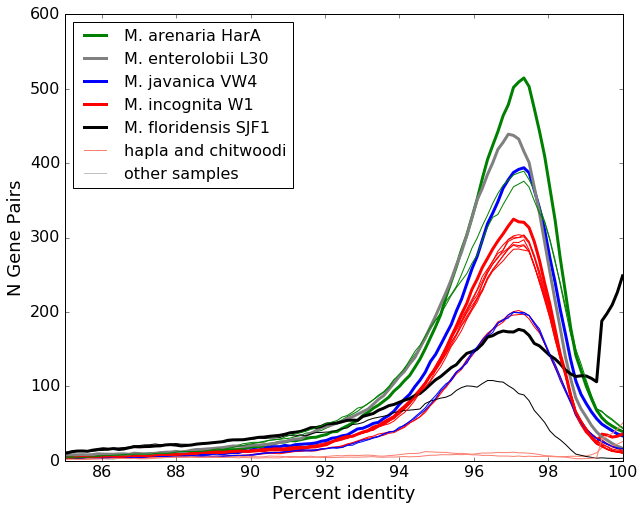

In [14]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import pickle
import glob
from collections import Counter
from itertools import chain
import numpy as np

# convert data point to sliding avarage
def smooth(a, half_window = 4):
    import numpy as np
    a = list(a)
    smoothed = []
    for i in range(len(a)):
        start = i - half_window
        end = i + half_window+1
        if start < 0:
            start = 0
        smoothed.append(np.mean(a[start:end]))
    return smoothed


# Load the data
with open('./intrablast_p_ident_dict.pkl','rb') as hndl:
    p_ident = pickle.load(hndl)

# plot the histograms
fig, ax = plt.subplots(figsize=(10,8))
bins = []

colors = {'Mjav':'blue','Mflo':'black','Mare':'green',
          'Minc':'red', 'Ment': 'gray'}

for smpl in p_ident:
    
    color = 'salmon'
    if smpl[:4] in colors:
        color = colors[smpl[:4]]    
    w = 1
    if '_ref' in smpl and not 'JB5' in smpl:
        w = 3
    
    d = p_ident[smpl]
    
    if len(bins) > 0:
        
        values, bins = np.histogram(d, bins=bins)
        
        a = ax.plot(bins[1:],
                    smooth(values),
                    color= color,
                    linewidth=w
                   )
        
    else:
        
        values, bins = np.histogram(d, bins=200)
          
        a = ax.plot(bins[1:],
                    smooth(values),
                    color= color,
                    linewidth=w,
                   )


# plot the axes        
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(16)
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(16)
      
ax.set_xlim(85,100)

plt.xlabel('Percent identity', fontsize=18)
plt.ylabel('N Gene Pairs', fontsize=18)

# Plot the legend
Mare_line = mlines.Line2D([0,1], [0,0], color='green',
                          linewidth=3, label='M. arenaria HarA')
Ment_line = mlines.Line2D([0,1], [0,0], color='gray',
                          linewidth=3, label='M. enterolobii L30')
Mjav_line = mlines.Line2D([0,1], [0,0], color='blue',
                          linewidth=3, label='M. javanica VW4')
Minc_line = mlines.Line2D([0,1], [0,0], color='red',
                          linewidth=3, label='M. incognita W1')
Mflo_line = mlines.Line2D([0,1], [0,0], color='black',
                          linewidth=3, label='M. floridensis SJF1')
hapchi_line = mlines.Line2D([0,1], [0,0], color='salmon',
                          linewidth=1, label='hapla and chitwoodi')
other = mlines.Line2D([0,1], [0,0], color='silver',
                          linewidth=1, label='other samples')

plt.legend(handles=[Mare_line,Ment_line,Mjav_line,
                    Minc_line,Mflo_line,hapchi_line,other],
           loc=2, fontsize = 16)

# Save the figure
plt.savefig('intra_blast.png', dpi=300)